In [1]:
from data.load_data import load_cache_behavior_neuropixel, get_trial_df
import numpy as np
import matplotlib.pyplot as plt # used for plotting data
%matplotlib inline
from numpy import linalg as LA
from numpy.linalg import matrix_rank
from scipy.stats import pearsonr, linregress
import my_functions_notebook as mf
from scipy.optimize import curve_fit


In [2]:
#loading cache and selecting the session
cache = load_cache_behavior_neuropixel()

number_of_sessions = 5
#sessions_to_iterate = cache.get_ecephys_session_table().index.values[:number_of_sessions]

sessions_to_iterate = [1053925378, 1081090969, 1064415305, 1108334384, 1115356973]
#3rd is the best, 4th is bad

In [3]:
#Brain region and quality matrix
my_area = 'VISp'
amplitude_cutoff_maximum = 0.1
presence_ratio_minimum = 0.9
isi_violations_maximum = 0.5

In [4]:
#get trial_df

#session_number = 31
#session_id = cache.get_ecephys_session_table().index.values[session_number]

session_id = sessions_to_iterate[3]
session = cache.get_ecephys_session(session_id)
trial_df = get_trial_df(session)

/root/capsule/code/data/load_data.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pres_df['image_int'] = pres_df.image_name.apply( lambda img: image_to_int[img] )


In [5]:
#select go-hit trials or go-miss trials
trials = session.trials
trial_df['stim_id'] = trial_df.index.values

#merge with trials features
m_df = trial_df.merge(right=trials, on='trials_id')
m_df.index = m_df.stim_id
m_df = m_df.sort_index()

#build the vector to get the type of trial per each trial

idx_hit_mode = np.zeros(trial_df.shape[0])
idx_miss_mode = np.zeros(trial_df.shape[0])

for i in range(0,trial_df.shape[0]):
    idx_hit_mode[i] = m_df.iloc[i].hit
    idx_miss_mode[i] = m_df.iloc[i].miss
    

In [70]:
np.sum(idx_hit_mode), np.sum(idx_miss_mode), trial_df.shape[0], np.sum(idx_hit_mode)/np.sum(idx_miss_mode)

(824.0, 1224.0, 2072, 0.673202614379085)

In [7]:
#get the spike data
VISp_units = mf.get_spike_data(cache, session, my_area, amplitude_cutoff_maximum, presence_ratio_minimum, isi_violations_maximum)

#get firing rates (and their normalized versions, where each firing rate is normalized with respect to its maximum)
    
firing_rates, norm_firing_rates, idx_image_int, idx_active, idx_image_order = mf.get_norm_firing_rates_per_stim_ID(VISp_units, session, trial_df)

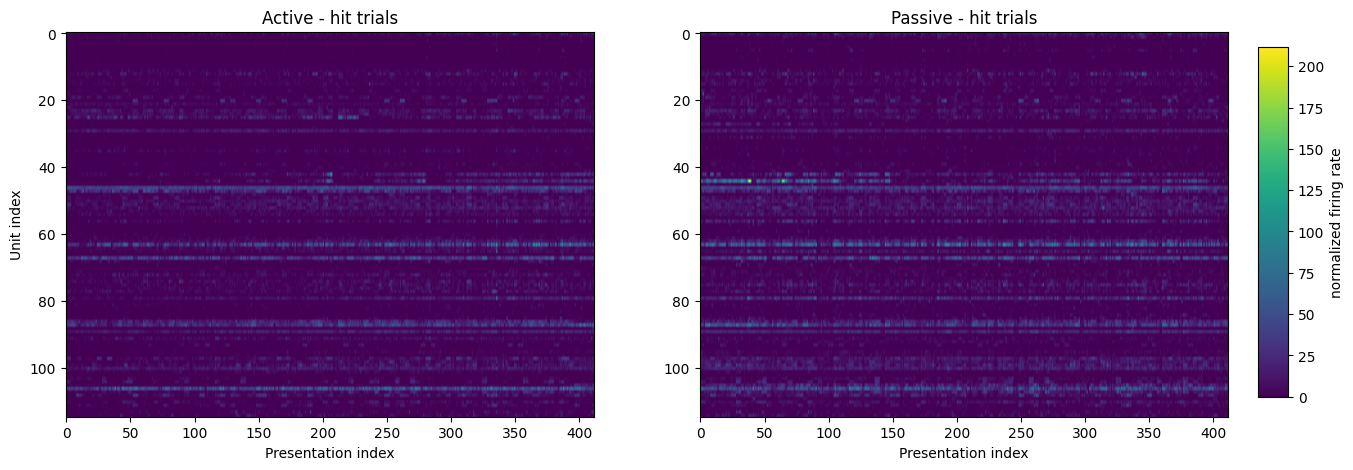

In [8]:
fig, axes = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

vmin = firing_rates.min()
vmax = firing_rates.max()

im1 = axes[0].imshow(firing_rates[:,(idx_active == True) & (idx_hit_mode == True)], cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[0].set_xlabel('Presentation index')
axes[0].set_ylabel('Unit index')
axes[0].set_title('Active - hit trials')

im2 = axes[1].imshow(firing_rates[:,(idx_active == False) & (idx_hit_mode == True)], cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[1].set_xlabel('Presentation index')
axes[1].set_title('Passive - hit trials')

# Create a colorbar on the right subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('normalized firing rate')


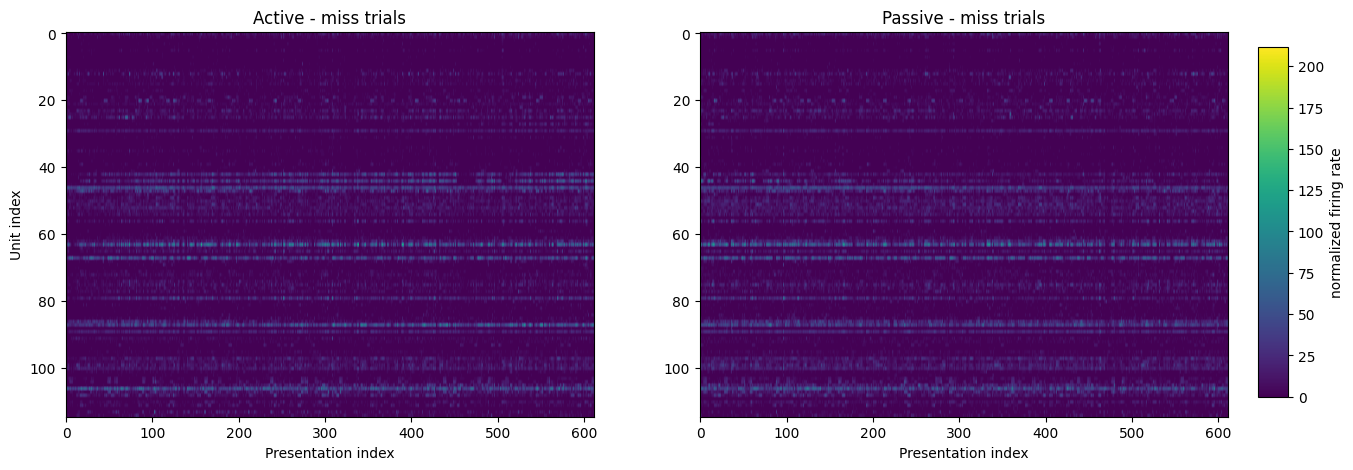

In [9]:
fig, axes = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

vmin = firing_rates.min()
vmax = firing_rates.max()

im1 = axes[0].imshow(firing_rates[:,(idx_active == True) & (idx_miss_mode == True)], cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[0].set_xlabel('Presentation index')
axes[0].set_ylabel('Unit index')
axes[0].set_title('Active - miss trials')

im2 = axes[1].imshow(firing_rates[:,(idx_active == False) & (idx_miss_mode == True)], cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[1].set_xlabel('Presentation index')
axes[1].set_title('Passive - miss trials')

# Create a colorbar on the right subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('normalized firing rate')

In [10]:
#just to make changes to the fucntions without restarting the kernel
import my_functions_notebook
import importlib
importlib.reload(my_functions_notebook)

<module 'my_functions_notebook' from '/root/capsule/local_notebooks/my_functions_notebook.py'>

In [11]:
#ORDER: active_mode, hit_mode, miss_mode, idx_hit_mode, idx_miss_mode

In [12]:
#select only the same stimuli with their presentation order

#select only miss trials for the bad session!!!!

#ACTIVE - hit trials only

mean_firing_rates_per_image_int_ACTIVE, mean_firing_rates_per_image_int_and_order_ACTIVE = mf.grouping_stimuli(VISp_units, firing_rates, trial_df, idx_active, idx_image_int, idx_image_order, True, False, True, idx_hit_mode, idx_miss_mode)

#PASSIVE - hit trials only

mean_firing_rates_per_image_int_PASSIVE, mean_firing_rates_per_image_int_and_order_PASSIVE = mf.grouping_stimuli(VISp_units, firing_rates, trial_df, idx_active, idx_image_int, idx_image_order, False, False, True, idx_hit_mode, idx_miss_mode)
                                                                  

In [13]:
#NOISE correlations

#select only miss trials for the bad session!!!!


#ACTIVE - hit trials only

noise_correlations_per_image_ACTIVE, noise_correlations_with_image_order_ACTIVE, mean_noise_correlations_ACTIVE, mean_noise_correlations_per_image_order_ACTIVE = mf.get_noise_correlations(trial_df, VISp_units, firing_rates, idx_image_int, idx_active, idx_image_order, True, False, True, idx_hit_mode, idx_miss_mode)

#PASSIVE - hit trials only

noise_correlations_per_image_PASSIVE, noise_correlations_with_image_order_PASSIVE, mean_noise_correlations_PASSIVE, mean_noise_correlations_per_image_order_PASSIVE = mf.get_noise_correlations(trial_df, VISp_units, firing_rates, idx_image_int, idx_active, idx_image_order, False, False, True, idx_hit_mode, idx_miss_mode)


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/root/capsule/local_notebooks/my_functions_notebook.py:105: RuntimeWarning: Mean of empty slice
  mean_noise_correlations_per_image_order = np.nanmean(noise_correlations_with_image_order,axis=2)
/root/capsule/local_notebooks/my_functions_notebook.py:97: RuntimeWarning: Mean of empty slice
  mean_noise_correlations = np.nanmean(noise_correlations_per_image,axis=2)


In [14]:
#SIGNAL correlations
#for signal correlations we just need to run np.corrcoef(mean_norm_firing_rates_per_image_int) or np.corrcoef(mean_norm_firing_rates_per_image_int_and_order[:,:,i]) if we want to divide them by order

#ACTIVE - hit trials only

signal_correlations_ACTIVE = np.corrcoef(mean_firing_rates_per_image_int_ACTIVE)
signal_correlations_per_image_order_ACTIVE = mf.get_signal_correlations_per_image_order(VISp_units, mean_firing_rates_per_image_int_and_order_ACTIVE)

#PASSIVE - hit trials only

signal_correlations_PASSIVE = np.corrcoef(mean_firing_rates_per_image_int_PASSIVE)
signal_correlations_per_image_order_PASSIVE = mf.get_signal_correlations_per_image_order(VISp_units, mean_firing_rates_per_image_int_and_order_PASSIVE)


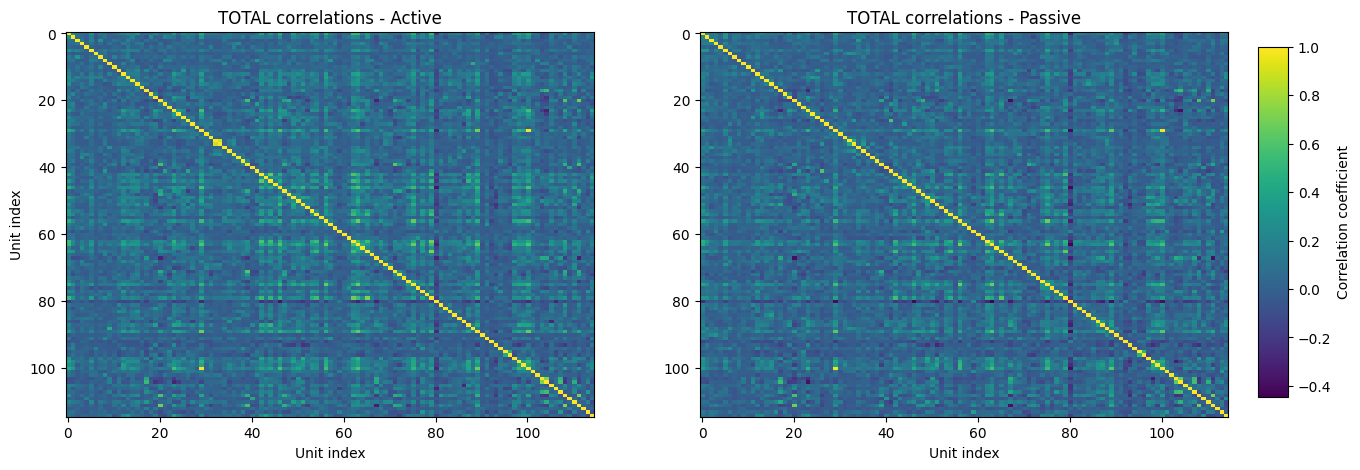

In [15]:
#TOTAL correlations

#select only miss trials for the bad session!

total_correlations_ACTIVE = np.corrcoef(firing_rates[:,(idx_active == True) & (idx_miss_mode == True)])
total_correlations_PASSIVE = np.corrcoef(firing_rates[:,(idx_active == False) & (idx_miss_mode == True)])

fig, axes = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

vmin = min(total_correlations_ACTIVE.min(), total_correlations_PASSIVE.min())
vmax = max(total_correlations_ACTIVE.max(), total_correlations_PASSIVE.max())

im1 = axes[0].imshow(total_correlations_ACTIVE, cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[0].set_xlabel('Unit index')
axes[0].set_ylabel('Unit index')
axes[0].set_title('TOTAL correlations - Active')

im2 = axes[1].imshow(total_correlations_PASSIVE, cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[1].set_xlabel('Unit index')
axes[1].set_title('TOTAL correlations - Passive')

# Create a colorbar on the right subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Correlation coefficient')


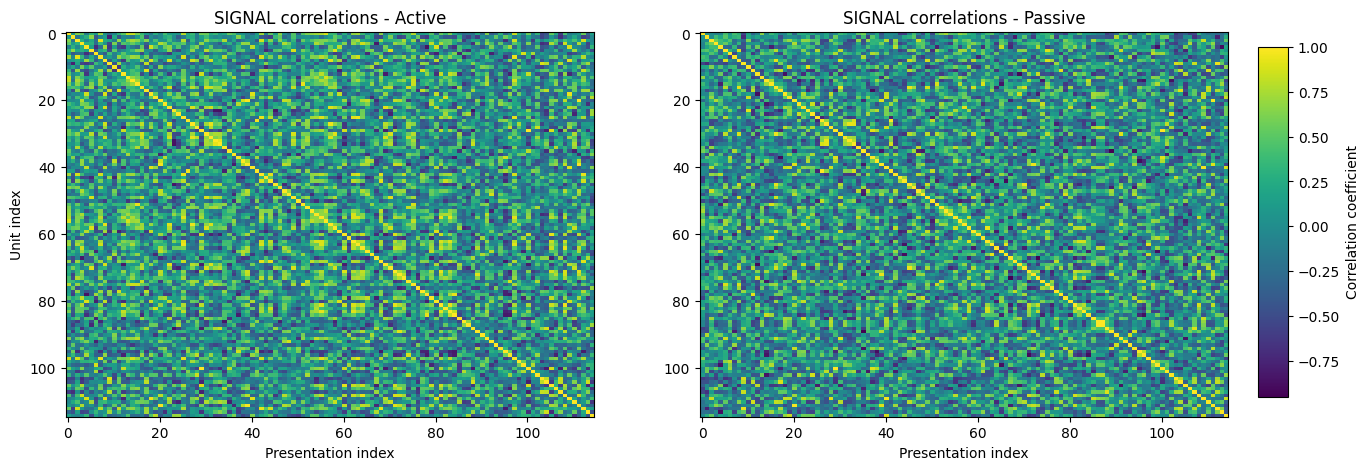

In [16]:
#SIGNAL correlations

fig, axes = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

vmin = min(signal_correlations_ACTIVE.min(), signal_correlations_PASSIVE.min())
vmax = max(signal_correlations_ACTIVE.max(), signal_correlations_PASSIVE.max())

im1 = axes[0].imshow(signal_correlations_ACTIVE, cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[0].set_xlabel('Presentation index')
axes[0].set_ylabel('Unit index')
axes[0].set_title('SIGNAL correlations - Active')

im2 = axes[1].imshow(signal_correlations_PASSIVE, cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[1].set_xlabel('Presentation index')
axes[1].set_title('SIGNAL correlations - Passive')

# Create a colorbar on the right subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Correlation coefficient')

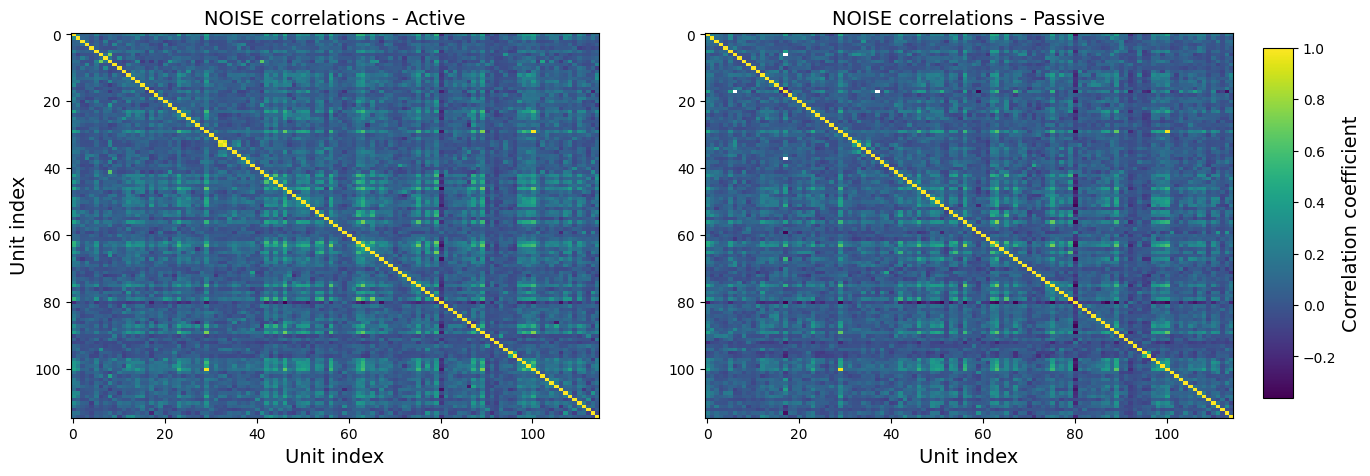

In [71]:
#NOISE correlations

fig, axes = plt.subplots(1,2, figsize=(15,5))  # 1 row, 2 columns

vmin = min(np.nanmin(mean_noise_correlations_ACTIVE), mean_noise_correlations_PASSIVE.min())
vmax = max(np.nanmax(mean_noise_correlations_ACTIVE), mean_noise_correlations_PASSIVE.max())

im1 = axes[0].imshow(mean_noise_correlations_ACTIVE, cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[0].set_xlabel('Unit index', fontsize = 14)
axes[0].set_ylabel('Unit index', fontsize = 14)
axes[0].set_title('NOISE correlations - Active', fontsize = 14)

im2 = axes[1].imshow(mean_noise_correlations_PASSIVE, cmap='viridis', aspect='auto', vmax=vmax, vmin = vmin)
axes[1].set_xlabel('Unit index', fontsize = 14)
axes[1].set_title('NOISE correlations - Passive', fontsize = 14)

# Create a colorbar on the right subplot
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Correlation coefficient', fontsize = 14)

plt.savefig('Noise_correlations_matrices_BAD_session.png')

Mean Noise Correlation - ACTIVE:
0.08053789947903545
Mean Signal Correlation - ACTIVE:
0.06771118418034504
Mean Noise Correlation - PASSIVE:
0.06458935292271464
Mean Signal Correlation - PASSIVE:
0.020601648162656905
Pearson - ACTIVE:
PearsonRResult(statistic=0.1464021929720391, pvalue=1.0114281796848513e-63)
Pearson - PASSIVE:
PearsonRResult(statistic=0.05511246629123012, pvalue=2.7270414531600823e-10)


Text(0, 0.5, 'Noise Correlation')

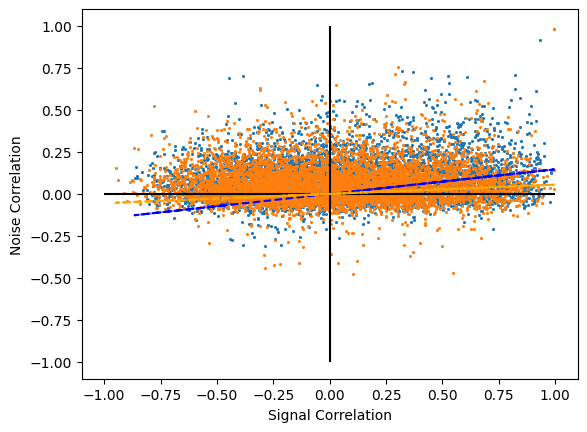

In [21]:
#SIGNAL and NOISE correlations --> comparison

ncorr_ACTIVE = np.matrix.flatten(mean_noise_correlations_ACTIVE)
indices_ACTIVE = np.where(ncorr_ACTIVE > 0.99) #remove the ones along the diagonal
ncorr_ACTIVE = np.delete(ncorr_ACTIVE, indices_ACTIVE)

ncorr_PASSIVE = np.matrix.flatten(mean_noise_correlations_PASSIVE)
indices_PASSIVE = np.where(ncorr_PASSIVE > 0.99) #remove the ones along the diagonal
ncorr_PASSIVE = np.delete(ncorr_PASSIVE, indices_PASSIVE)

scorr_ACTIVE = np.matrix.flatten(signal_correlations_ACTIVE)
scorr_ACTIVE = np.delete(scorr_ACTIVE,indices_ACTIVE)

scorr_PASSIVE = np.matrix.flatten(signal_correlations_PASSIVE)
scorr_PASSIVE = np.delete(scorr_PASSIVE,indices_PASSIVE)

print('Mean Noise Correlation - ACTIVE:')
print(np.nanmean(ncorr_ACTIVE))

print('Mean Signal Correlation - ACTIVE:')
print(np.nanmean(scorr_ACTIVE))

print('Mean Noise Correlation - PASSIVE:')
print(np.nanmean(ncorr_PASSIVE))

print('Mean Signal Correlation - PASSIVE:')
print(np.nanmean(scorr_PASSIVE))

#compute pearson corr
pearson_ACTIVE = pearsonr(ncorr_ACTIVE[np.isnan(ncorr_ACTIVE)==False],scorr_ACTIVE[np.isnan(ncorr_ACTIVE)==False])
pearson_PASSIVE = pearsonr(ncorr_PASSIVE[np.isnan(ncorr_PASSIVE)==False],scorr_PASSIVE[np.isnan(ncorr_PASSIVE)==False])

print('Pearson - ACTIVE:')
print(pearson_ACTIVE)

print('Pearson - PASSIVE:')
print(pearson_PASSIVE)

#linear fit

#plot
plt.scatter(scorr_ACTIVE,ncorr_ACTIVE,s=1, label = 'ACTIVE')
plt.scatter(scorr_PASSIVE,ncorr_PASSIVE,s=1, label = 'PASSIVE')

# Plot the linear regression lines
plt.plot(scorr_ACTIVE, pearson_ACTIVE[0]  * scorr_ACTIVE, color='blue', linestyle='--', label='ACTIVE Regression')
plt.plot(scorr_PASSIVE, pearson_PASSIVE[0] * scorr_PASSIVE , color='orange', linestyle='--', label='PASSIVE Regression')

plt.hlines(0,-1,1,colors='black')
plt.vlines(0,-1,1,colors='black')
plt.xlabel('Signal Correlation')
plt.ylabel('Noise Correlation')


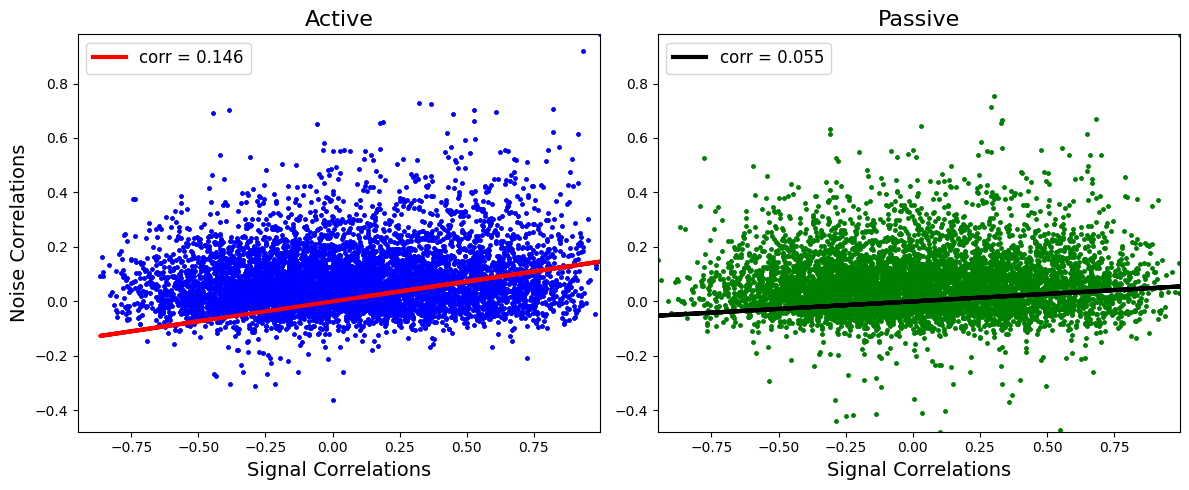

In [73]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

# Find the common limits for both x and y axes
common_xlim = (min(scorr_PASSIVE), max(scorr_ACTIVE))
common_ylim = (min(ncorr_PASSIVE), max(ncorr_ACTIVE))

# Scatter plot on the first subplot
ax1.scatter(scorr_ACTIVE, ncorr_ACTIVE, c='b', s=5)
ax1.plot(scorr_ACTIVE, pearson_ACTIVE[0]  * scorr_ACTIVE, 'r', label = 'corr = 0.146',linewidth=3)

# Customize the first subplot
ax1.set_ylabel('Noise Correlations', fontsize=14)
ax1.set_xlabel('Signal Correlations', fontsize=14)
ax1.set_title('Active', fontsize=16)
ax1.legend(loc='upper left', fontsize=12)

# Set common x and y limits for both subplots
ax1.set_xlim(common_xlim)
ax1.set_ylim(common_ylim)

# Scatter plot on the second subplot
ax2.scatter(scorr_PASSIVE, ncorr_PASSIVE, c='g', s=5, marker='o')
ax2.plot(scorr_PASSIVE, pearson_PASSIVE[0]  * scorr_PASSIVE, 'black', label = 'corr = 0.055',linewidth=3)

# Customize the second subplot
#ax2.set_ylabel('Noise Correlations', fontsize=14)
ax2.set_xlabel('Signal Correlations', fontsize=14)
ax2.set_title('Passive', fontsize=16)
ax2.legend(loc='upper left', fontsize=12)

# Set common x and y limits for both subplots
ax2.set_xlim(common_xlim)
ax2.set_ylim(common_ylim)

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot to a file (optional)
# plt.savefig('scatter_plot_paper.png', dpi=300, bbox_inches='tight')

# Show the plot

plt.savefig('BAD_session_Noise_Signal_Correlations.png')
plt.show()

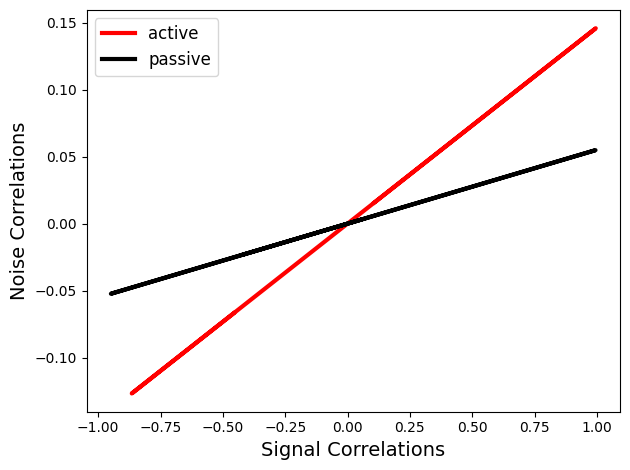

In [75]:
# Create a figure with two subplots side by side

# Scatter plot on the first subplot
plt.plot(scorr_ACTIVE, pearson_ACTIVE[0]  * scorr_ACTIVE, 'r', label = 'active', linewidth=3)
plt.plot(scorr_PASSIVE, pearson_PASSIVE[0]  * scorr_PASSIVE, 'black', label = 'passive',linewidth=3)

# Customize the first subplot
plt.ylabel('Noise Correlations', fontsize=14)
plt.xlabel('Signal Correlations', fontsize=14)
#plt.title('Active', fontsize=16)
plt.legend(loc='upper left', fontsize=12)

#plt.hlines(0,-1,1,colors='black', linestyle='--')
#plt.vlines(0,-1,1,colors='black', linestyle='--')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot to a file (optional)
# plt.savefig('scatter_plot_paper.png', dpi=300, bbox_inches='tight')

# Show the plot
#plt.show()
plt.savefig('BAD_session_Noise_Signal_Correlations_FITS.png')

In [54]:
slope_active, intercept_active, slope_passive, intercept_passive

(0.019122327858678626,
 0.03007013228726898,
 0.05922569775315231,
 0.019865555319737216)

In [55]:
# Define the linear function to fit
def linear_function(x, a):
    return a * x

# Fit the data using curve_fit
params, covariance = curve_fit(linear_function, scorr_ACTIVE, ncorr_ACTIVE)

# Fit the data using curve_fit
params_p, covariance_p = curve_fit(linear_function, scorr_PASSIVE, ncorr_PASSIVE)

params[0], params_p[0]

(0.010732950571424697, 0.030009484318787548)

In [56]:
#let's check if a rotation could map the spaces spanned by the two correlation matrices

def is_rotation(eigenvectors_A, eigenvectors_B):
    # Check if the dimensions match
    if eigenvectors_A.shape != eigenvectors_B.shape:
        return False
    
    # Compute the rotation matrix
    rotation_matrix = np.dot(eigenvectors_A, eigenvectors_B.T)
    
    # Check if it's a valid rotation matrix (orthogonal with determinant 1)
    if not np.allclose(np.dot(rotation_matrix, rotation_matrix.T), np.identity(rotation_matrix.shape[0])):
        return False
    
    if not np.isclose(np.abs(np.linalg.det(rotation_matrix)), 1.0):
        return False
    
    return True

#compute the eigenvectors

eigenvalues_SC_A, eigenvectors_SC_A = LA.eig(signal_correlations_ACTIVE)
eigenvalues_NC_A, eigenvectors_NC_A = LA.eig(np.nan_to_num(mean_noise_correlations_ACTIVE, nan = 0))

eigenvalues_SC_P, eigenvectors_SC_P = LA.eig(signal_correlations_PASSIVE)
eigenvalues_NC_P, eigenvectors_NC_P = LA.eig(np.nan_to_num(mean_noise_correlations_PASSIVE, nan = 0))

# Check if a simple rotation can map space A to space B
if is_rotation(eigenvectors_NC_A, eigenvectors_NC_P):
    print("An orthogonal transformation can map space A to space B.")
else:
    print("An orthogonal transformation cannot map space A to space B.")

rotation_matrix = np.dot(eigenvectors_NC_A, eigenvectors_NC_P.T) #it transforms vector from space NC_P to space NC_A

#as a prove, we project all the eigenvectors from one space to the other

dist_vec = np.zeros(93)

for i in range(0,93):
    dist_vec[i] = np.sum(np.abs(np.dot(rotation_matrix,eigenvectors_NC_P[:,i])-eigenvectors_NC_A[:,i]))
print("Mean of the distance between eignevectors:")    
print(np.mean(np.abs(dist_vec)))
print("The determinant is  -1, therefore we don't have a rotation")

An orthogonal transformation can map space A to space B.


IndexError: index 48 is out of bounds for axis 1 with size 48

In [ ]:
#let's compute also the ranks of the other matrices
matrix_rank(signal_correlations_ACTIVE),matrix_rank(signal_correlations_PASSIVE),matrix_rank(np.nan_to_num(mean_noise_correlations_ACTIVE, nan = 0)), matrix_rank(np.nan_to_num(mean_noise_correlations_PASSIVE, nan = 0))

In [ ]:
print("The rank of the matrices doesn't change across conditions")